In [1]:
#!pip install  plotly_express
#!pip install nbconvert
#!pip install -U notebook-as-pdf

In [2]:
import requests
import geopy
import time
import random
from geopy.geocoders import Nominatim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from scipy.cluster.hierarchy import linkage, dendrogram
import plotly 
import plotly.offline as py
import plotly.graph_objs as go
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
# empty list to place our data for each page
lst = []
API_KEY = "XhwAXVpj3nrNgikNQREOaW4XXyVvMBwQV_9L9mKp-kIawTch1UpoXOBhWPTr9Qnvar-FCz_8u4Dic3DMDXIy1o69Mm-Tj-hEFtTo5x84wY8YxxXjFhlVn4K9CFfjZXYx"
# our offset parameter - each page 50 rows
offset = 0
print('initial offset number: {}'.format(offset))

# loop through the api 20 times (limit is 1000 rows with each page includes 50 rows)
for i in range(20):
    
    try:
        headers = {'Authorization': 'Bearer {}'.format(API_KEY)}
        search_api_url = 'https://api.yelp.com/v3/businesses/search'
        params = {'term': 'food', 
                  'categories': 'restaurants',
                  'location': 'Texas', #If we will change here we can do the project on a different city
                  'offset': offset,
                  'limit': 50}

        response = requests.get(search_api_url, 
                                headers=headers, 
                                params=params, 
                                timeout=10)

        # return a dictionary
        data_dict = response.json()
        
        # convert the business dictionary to a pandas dataframe and append to list
        data = pd.DataFrame(data_dict['businesses'])
        lst.append(data)
      
        # add 50 to the offset to access a new page
        offset += 50
        print('current offset number: {}'.format(offset))
        
    except Exception as ex:
        print('exception: {}\nexit loop.'.format(ex))
        break

# concatenate all pages to one dataframe and reset index
df = pd.concat(lst)
df = df.reset_index(drop=True)

# review shape of dataframe
rows, columns = df.shape
print()
print('query includes {:,} rows and {} columns.'.format(rows, columns))
print('row id is unique: {}.'.format(df['id'].is_unique))

# review if dataframe id is unique, if not drop duplicates
if df['id'].is_unique == False:
    duplicates = df.loc[df.duplicated(subset=['id'])]
    vals = list(duplicates.head()['name'].values)
    print('\nduplicates found: {}.'.format(vals))
    
    df = df.drop_duplicates(subset=['id']).reset_index(drop=True)
    print('dropping duplicates...')
    
    rows, columns = df.shape
    print('\nrow id is unique: {}.'.format(df['id'].is_unique))
    print('query includes {:,} rows and {} columns.'.format(rows, columns))



initial offset number: 0
current offset number: 50
current offset number: 100
current offset number: 150
current offset number: 200
current offset number: 250
current offset number: 300
current offset number: 350
current offset number: 400
current offset number: 450
current offset number: 500
current offset number: 550
current offset number: 600
current offset number: 650
current offset number: 700
current offset number: 750
current offset number: 800
current offset number: 850
current offset number: 900
current offset number: 950
current offset number: 1000

query includes 1,000 rows and 16 columns.
row id is unique: False.

duplicates found: ["Flip 'n Patties - Energy Corridor", 'Coral Sword', 'Lazy Dog Restaurant & Bar', 'The Peri Peri Factory', 'Guadalajara Del Centro'].
dropping duplicates...

row id is unique: True.
query includes 990 rows and 16 columns.


In [4]:
df.head()

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance
0,uxC7VWWWK6PQOvNw0-fOnA,tumble-22-houston-2,Tumble 22,https://s3-media3.fl.yelpcdn.com/bphoto/VeZSTb...,False,https://www.yelp.com/biz/tumble-22-houston-2?a...,106,"[{'alias': 'chickenshop', 'title': 'Chicken Sh...",4.6,"{'latitude': 29.7679, 'longitude': -95.372638}","[pickup, delivery]",$$,"{'address1': '1017 Houston Ave', 'address2': N...",+12815009190,(281) 500-9190,1342.085651
1,3Xc_c-5wLZMbVVNX8KuuAQ,xeo-yum-houston,Xeo Yum,https://s3-media3.fl.yelpcdn.com/bphoto/BEjVzQ...,False,https://www.yelp.com/biz/xeo-yum-houston?adjus...,52,"[{'alias': 'vietnamese', 'title': 'Vietnamese'}]",4.7,"{'latitude': 29.746456, 'longitude': -95.377976}","[pickup, delivery]",NaN,"{'address1': '606 Dennis St', 'address2': 'Ste...",+18322028812,(832) 202-8812,2535.464027
2,n8MvjjhuUg8NAQKinUASHw,underground-hall-houston,Underground Hall,https://s3-media3.fl.yelpcdn.com/bphoto/feu0KK...,False,https://www.yelp.com/biz/underground-hall-hous...,132,"[{'alias': 'food_court', 'title': 'Food Court'...",4.4,"{'latitude': 29.76038, 'longitude': -95.36162}",[delivery],$$,"{'address1': '1010 Prairie St', 'address2': No...",+12818884323,(281) 888-4323,351.703073
3,4CAHyzS0hBcd8X5bEQps5g,chopnblok-houston,ChopnBlok,https://s3-media4.fl.yelpcdn.com/bphoto/wMEKY6...,False,https://www.yelp.com/biz/chopnblok-houston?adj...,217,"[{'alias': 'african', 'title': 'African'}]",4.8,"{'latitude': 29.76614, 'longitude': -95.36488}",[],$$,"{'address1': '401 Franklin St', 'address2': 'S...",+12816315009,(281) 631-5009,593.400657
4,bSkX_JIy-fUqDCjaXmiOdA,yoyo-s-hot-dogs-houston,Yoyo’s Hot Dogs,https://s3-media2.fl.yelpcdn.com/bphoto/NRSrbZ...,False,https://www.yelp.com/biz/yoyo-s-hot-dogs-houst...,26,"[{'alias': 'hotdog', 'title': 'Hot Dogs'}, {'a...",4.8,"{'latitude': 29.766230034039577, 'longitude': ...",[],NaN,"{'address1': '401 Franklin St', 'address2': ''...",+17138396207,(713) 839-6207,594.926045


In [5]:
# Export DataFrame to CSV
df.to_csv("Yelp_Restaurant.csv")
# Read the CSV file
df_read = pd.read_csv('Yelp_Restaurant.csv')

# Cleaning The Data #
## and adding some features ##

In [6]:
df[["latitude","longitude"]] = df["coordinates"].apply(pd.Series)

max_num_addresses = df['location'].apply(lambda x: len(x) if isinstance(x, dict) else 0).max()

for i in range(1, max_num_addresses + 1):
    col_name = f'address_{i}'
    df[col_name] = df['location'].apply(lambda x: x.get(f'address{i}', None) if isinstance(x, dict) else None)

df = df.drop(columns=['coordinates'])

none_count = df.isna().sum()
print(none_count)

# Remove columns 'address_4', 'address_5', 'address_6', 'address_7', 'address_8' if they exist
columns_to_drop = [f'address_{i}' for i in range(4, 9)]
df = df.drop(columns=columns_to_drop, errors='ignore')

df.head()


id                 0
alias              0
name               0
image_url          0
is_closed          0
url                0
review_count       0
categories         0
rating             0
transactions       0
price            320
location           0
phone              0
display_phone      0
distance           0
latitude           0
longitude          0
address_1          7
address_2        242
address_3        448
address_4        990
address_5        990
address_6        990
address_7        990
address_8        990
dtype: int64


,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,price,location,phone,display_phone,distance,latitude,longitude,address_1,address_2,address_3
0,uxC7VWWWK6PQOvNw0-fOnA,tumble-22-houston-2,Tumble 22,https://s3-media3.fl.yelpcdn.com/bphoto/VeZSTb...,False,https://www.yelp.com/biz/tumble-22-houston-2?a...,106,"[{'alias': 'chickenshop', 'title': 'Chicken Sh...",4.6,"[pickup, delivery]",$$,"{'address1': '1017 Houston Ave', 'address2': N...",+12815009190,(281) 500-9190,1342.085651,29.767900,-95.372638,1017 Houston Ave,None,
1,3Xc_c-5wLZMbVVNX8KuuAQ,xeo-yum-houston,Xeo Yum,https://s3-media3.fl.yelpcdn.com/bphoto/BEjVzQ...,False,https://www.yelp.com/biz/xeo-yum-houston?adjus...,52,"[{'alias': 'vietnamese', 'title': 'Vietnamese'}]",4.7,"[pickup, delivery]",NaN,"{'address1': '606 Dennis St', 'address2': 'Ste...",+18322028812,(832) 202-8812,2535.464027,29.746456,-95.377976,606 Dennis St,Ste 211,None
2,n8MvjjhuUg8NAQKinUASHw,underground-hall-houston,Underground Hall,https://s3-media3.fl.yelpcdn.com/bphoto/feu0KK...,False,https://www.yelp.com/biz/underground-hall-hous...,132,"[{'alias': 'food_court', 'title': 'Food Court'...",4.4,[delivery],$$,"{'address1': '1010 Prairie St', 'address2': No...",+12818884323,(281) 888-4323,351.703073,29.760380,-95.361620,1010 Prairie St,None,
3,4CAHyzS0hBcd8X5bEQps5g,chopnblok-houston,ChopnBlok,https://s3-media4.fl.yelpcdn.com/bphoto/wMEKY6...,False,https://www.yelp.com/biz/chopnblok-houston?adj...,217,"[{'alias': 'african', 'title': 'African'}]",4.8,[],$$,"{'address1': '401 Franklin St', 'address2': 'S...",+12816315009,(281) 631-5009,593.400657,29.766140,-95.364880,401 Franklin St,Ste A,
4,bSkX_JIy-fUqDCjaXmiOdA,yoyo-s-hot-dogs-houston,Yoyo’s Hot Dogs,https://s3-media2.fl.yelpcdn.com/bphoto/NRSrbZ...,False,https://www.yelp.com/biz/yoyo-s-hot-dogs-houst...,26,"[{'alias': 'hotdog', 'title': 'Hot Dogs'}, {'a...",4.8,[],NaN,"{'address1': '401 Franklin St', 'address2': ''...",+17138396207,(713) 839-6207,594.926045,29.766230,-95.364891,401 Franklin St,,None


In [7]:
df.dtypes
df['is_closed'] = (df['is_closed'] == False).astype(int)
df

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,price,location,phone,display_phone,distance,latitude,longitude,address_1,address_2,address_3
0,uxC7VWWWK6PQOvNw0-fOnA,tumble-22-houston-2,Tumble 22,https://s3-media3.fl.yelpcdn.com/bphoto/VeZSTb...,1,https://www.yelp.com/biz/tumble-22-houston-2?a...,106,"[{'alias': 'chickenshop', 'title': 'Chicken Sh...",4.6,"[pickup, delivery]",$$,"{'address1': '1017 Houston Ave', 'address2': N...",+12815009190,(281) 500-9190,1342.085651,29.767900,-95.372638,1017 Houston Ave,None,
1,3Xc_c-5wLZMbVVNX8KuuAQ,xeo-yum-houston,Xeo Yum,https://s3-media3.fl.yelpcdn.com/bphoto/BEjVzQ...,1,https://www.yelp.com/biz/xeo-yum-houston?adjus...,52,"[{'alias': 'vietnamese', 'title': 'Vietnamese'}]",4.7,"[pickup, delivery]",NaN,"{'address1': '606 Dennis St', 'address2': 'Ste...",+18322028812,(832) 202-8812,2535.464027,29.746456,-95.377976,606 Dennis St,Ste 211,None
2,n8MvjjhuUg8NAQKinUASHw,underground-hall-houston,Underground Hall,https://s3-media3.fl.yelpcdn.com/bphoto/feu0KK...,1,https://www.yelp.com/biz/underground-hall-hous...,132,"[{'alias': 'food_court', 'title': 'Food Court'...",4.4,[delivery],$$,"{'address1': '1010 Prairie St', 'address2': No...",+12818884323,(281) 888-4323,351.703073,29.760380,-95.361620,1010 Prairie St,None,
3,4CAHyzS0hBcd8X5bEQps5g,chopnblok-houston,ChopnBlok,https://s3-media4.fl.yelpcdn.com/bphoto/wMEKY6...,1,https://www.yelp.com/biz/chopnblok-houston?adj...,217,"[{'alias': 'african', 'title': 'African'}]",4.8,[],$$,"{'address1': '401 Franklin St', 'address2': 'S...",+12816315009,(281) 631-5009,593.400657,29.766140,-95.364880,401 Franklin St,Ste A,
4,bSkX_JIy-fUqDCjaXmiOdA,yoyo-s-hot-dogs-houston,Yoyo’s Hot Dogs,https://s3-media2.fl.yelpcdn.com/bphoto/NRSrbZ...,1,https://www.yelp.com/biz/yoyo-s-hot-dogs-houst...,26,"[{'alias': 'hotdog', 'title': 'Hot Dogs'}, {'a...",4.8,[],NaN,"{'address1': '401 Franklin St', 'address2': ''...",+17138396207,(713) 839-6207,594.926045,29.766230,-95.364891,401 Franklin St,,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,tZ9gK_Pqb-DYWxRPduR6Gw,chicken-n-pickle-webster-2,Chicken N Pickle,https://s3-media4.fl.yelpcdn.com/bphoto/1v4jma...,1,https://www.yelp.com/biz/chicken-n-pickle-webs...,14,"[{'alias': 'venues', 'title': 'Venues & Event ...",3.4,[],NaN,"{'address1': '210 Blue Heron Dr', 'address2': ...",+12818497430,(281) 849-7430,36146.099288,29.515002,-95.118191,210 Blue Heron Dr,,None
986,iDDQ_5y_fzqDfpon_NmgWw,el-alebrije-oaxacan-streetfood-houston-2,El Alebrije Oaxacan Streetfood,https://s3-media2.fl.yelpcdn.com/bphoto/vmtAcK...,1,https://www.yelp.com/biz/el-alebrije-oaxacan-s...,17,"[{'alias': 'foodtrucks', 'title': 'Food Trucks...",4.4,"[delivery, pickup]",NaN,"{'address1': '4816 N Shepherd Dr', 'address2':...",+18325303421,(832) 530-3421,9401.680652,29.835449,-95.410236,4816 N Shepherd Dr,Ste a,
987,O-mwVJT-LYrInolydsbIfA,the-waffle-bus-houston-5,The Waffle Bus,https://s3-media3.fl.yelpcdn.com/bphoto/KFYkUQ...,1,https://www.yelp.com/biz/the-waffle-bus-housto...,171,"[{'alias': 'waffles', 'title': 'Waffles'}, {'a...",3.9,"[delivery, pickup]",$$,"{'address1': '1540 W Alabama St', 'address2': ...",,,4618.829716,29.738953,-95.398901,1540 W Alabama St,Ste 100,None
988,UhmEtZvRndkEfEj2UCcbkw,khaosan-road-thai-cuisine-houston,Khaosan Road Thai Cuisine,https://s3-media1.fl.yelpcdn.com/bphoto/i4soE0...,1,https://www.yelp.com/biz/khaosan-road-thai-cui...,287,"[{'alias': 'thai', 'title': 'Thai'}, {'alias':...",3.9,"[delivery, pickup]",$$,"{'address1': '4822 Fulton St', 'address2': '',...",+17138637074,(713) 863-7074,4615.850499,29.803920,-95.368171,4822 Fulton St,,


## Visualizations ##

In [8]:
top_restaurants = df.sort_values(by=['review_count', 'rating'], ascending=False)[:10]
top_restaurants.head(10)


,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,price,location,phone,display_phone,distance,latitude,longitude,address_1,address_2,address_3
5,NNMvUp-r7sQt7Q2l-kO9wA,the-breakfast-klub-houston-2,The Breakfast Klub,https://s3-media4.fl.yelpcdn.com/bphoto/g8NDOI...,1,https://www.yelp.com/biz/the-breakfast-klub-ho...,6092,"[{'alias': 'breakfast_brunch', 'title': 'Break...",4.5,"[pickup, delivery]",$$,"{'address1': '3711 Travis St', 'address2': '',...",+17135288561,(713) 528-8561,3370.053899,29.738430,-95.380480,3711 Travis St,,
59,MtrXTHsxOCw0iCtOlPhrGQ,jinya-ramen-bar-houston-houston,JINYA Ramen Bar - Houston,https://s3-media1.fl.yelpcdn.com/bphoto/0T33BB...,1,https://www.yelp.com/biz/jinya-ramen-bar-houst...,3529,"[{'alias': 'ramen', 'title': 'Ramen'}, {'alias...",4.3,"[pickup, delivery]",$$,"{'address1': '3201 Louisiana St', 'address2': ...",+18329258596,(832) 925-8596,2960.141681,29.742724,-95.379789,3201 Louisiana St,Ste 105,
762,haOLj8uMDwmZTNsJ7_HSjg,agas-restaurant-and-catering-houston-14,Aga's Restaurant & Catering,https://s3-media2.fl.yelpcdn.com/bphoto/3z_XIu...,1,https://www.yelp.com/biz/agas-restaurant-and-c...,2936,"[{'alias': 'indpak', 'title': 'Indian'}]",4.6,[delivery],$$,"{'address1': '11842 Wilcrest Dr', 'address2': ...",+18327868000,(832) 786-8000,23721.621589,29.649143,-95.567697,11842 Wilcrest Dr,,
27,RoU8KznQMrRFcIjYVtdZMw,the-pit-room-houston,The Pit Room,https://s3-media3.fl.yelpcdn.com/bphoto/KkligA...,1,https://www.yelp.com/biz/the-pit-room-houston?...,2908,"[{'alias': 'bbq', 'title': 'Barbeque'}, {'alia...",4.3,"[pickup, delivery]",$$,"{'address1': '1201 Richmond Ave', 'address2': ...",+12818881929,(281) 888-1929,4585.949511,29.734235,-95.393968,1201 Richmond Ave,,
129,1Xg9YJ6EcFKYdWCLyWwn1A,killens-barbecue-pearland-4,Killen's Barbecue,https://s3-media2.fl.yelpcdn.com/bphoto/i6bC4U...,1,https://www.yelp.com/biz/killens-barbecue-pear...,2815,"[{'alias': 'bbq', 'title': 'Barbeque'}, {'alia...",4.2,"[delivery, pickup]",$$,"{'address1': '3613 E Broadway', 'address2': ''...",+12814852272,(281) 485-2272,23365.076039,29.564033,-95.282281,3613 E Broadway,,
355,237MSviehmCzD_wwKg4-zA,bosscat-kitchen-and-libations-houston,Bosscat Kitchen & Libations,https://s3-media4.fl.yelpcdn.com/bphoto/CUsonA...,1,https://www.yelp.com/biz/bosscat-kitchen-and-l...,2763,"[{'alias': 'newamerican', 'title': 'New Americ...",4.3,"[delivery, pickup]",$$,"{'address1': '4310 Westheimer Rd', 'address2':...",+12815011187,(281) 501-1187,9068.955786,29.741800,-95.450518,4310 Westheimer Rd,Ste 150,None
513,NeTU3xFecz5vIeVWmd8LOw,dish-society-houston,Dish Society,https://s3-media2.fl.yelpcdn.com/bphoto/ANr_lx...,1,https://www.yelp.com/biz/dish-society-houston?...,2646,"[{'alias': 'breakfast_brunch', 'title': 'Break...",4.3,"[pickup, delivery]",$$,"{'address1': '5740 San Felipe St', 'address2':...",+18325381060,(832) 538-1060,11560.462512,29.750510,-95.478690,5740 San Felipe St,Ste 100,
124,sICvh8l9t31JcDgwweNe8A,turkey-leg-hut-houston-4,Turkey Leg Hut,https://s3-media2.fl.yelpcdn.com/bphoto/9zXTef...,1,https://www.yelp.com/biz/turkey-leg-hut-housto...,2601,"[{'alias': 'southern', 'title': 'Southern'}, {...",3.9,[delivery],$$,"{'address1': '4830 Almeda Rd', 'address2': 'St...",+18327870770,(832) 787-0770,4467.803118,29.725999,-95.377926,4830 Almeda Rd,Ste A-B,None
328,x4WealiPVG-tzwzhe7nvpw,north-italia-houston,North Italia,https://s3-media3.fl.yelpcdn.com/bphoto/jNVzNb...,1,https://www.yelp.com/biz/north-italia-houston?...,2351,"[{'alias': 'pizza', 'title': 'Pizza'}, {'alias...",4.3,[delivery],$$,"{'address1': '1700 Post Oak Blvd', 'address2':...",+12816054030,(281) 605-4030,9983.179391,29.748587,-95.462025,1700 Post Oak Blvd,Ste 190,
134,9MKqG6XgUEdErB5zfH5faA,niko-nikos-greek-and-american-cafe-houston-4,Niko Niko's Greek & American Cafe,https://s3-media2.fl.yelpcdn.com/bphoto/RtZ77E...,1,https://www.yelp.com/biz/niko-nikos-greek-and-...,2274,"[{'alias': 'greek', 'title': 'Greek'}, {'alias...",4.0,[deliv

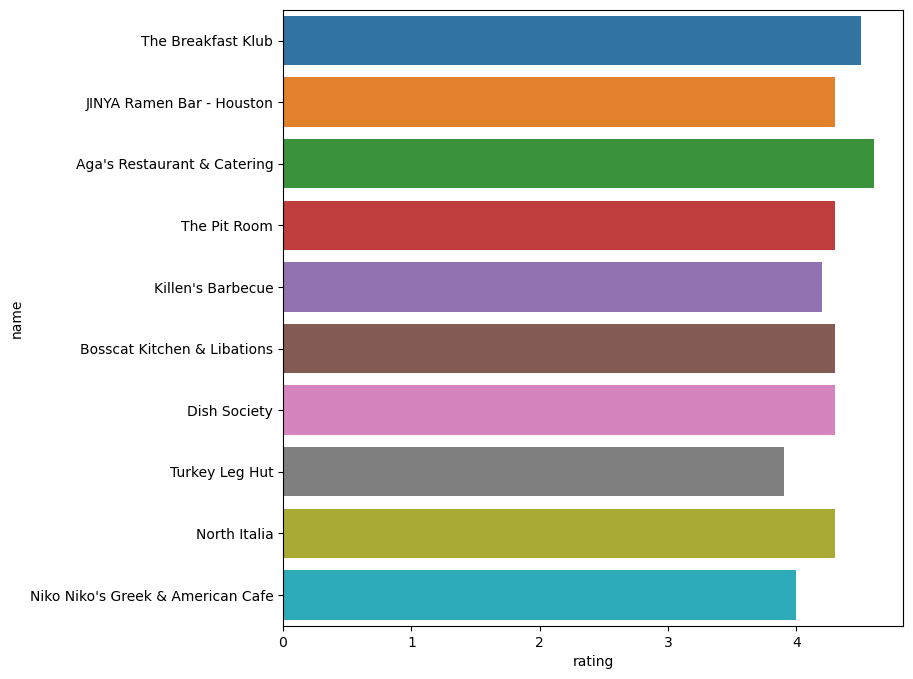

In [9]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x = 'rating', y = 'name', data=top_restaurants, ax= ax)
plt.show()

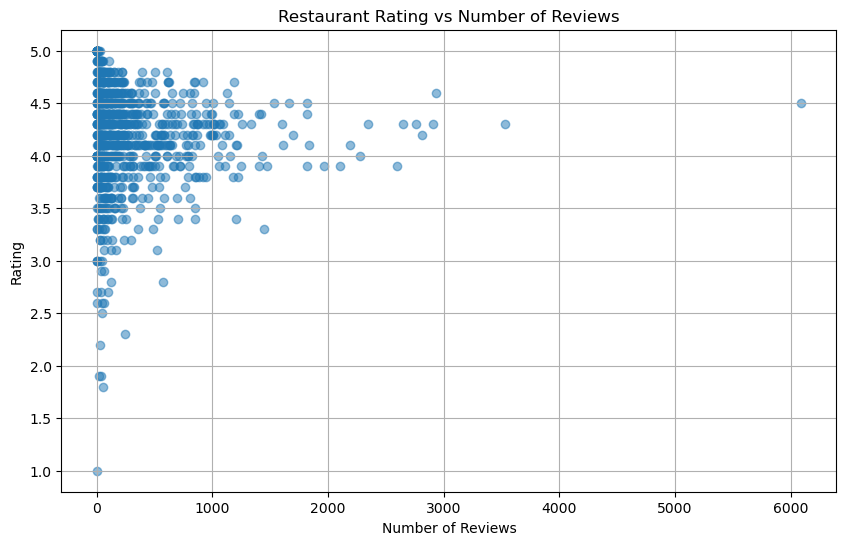

In [10]:
plt.figure(figsize=(10, 6))
plt.scatter(df['review_count'], df['rating'], alpha=0.5)
plt.title('Restaurant Rating vs Number of Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('Rating')
plt.grid(True)
plt.show()

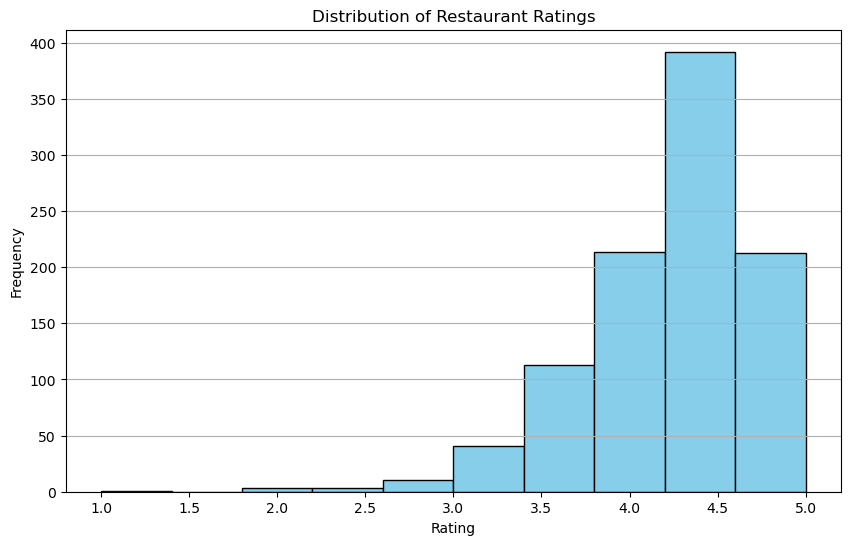

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(df['rating'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Restaurant Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

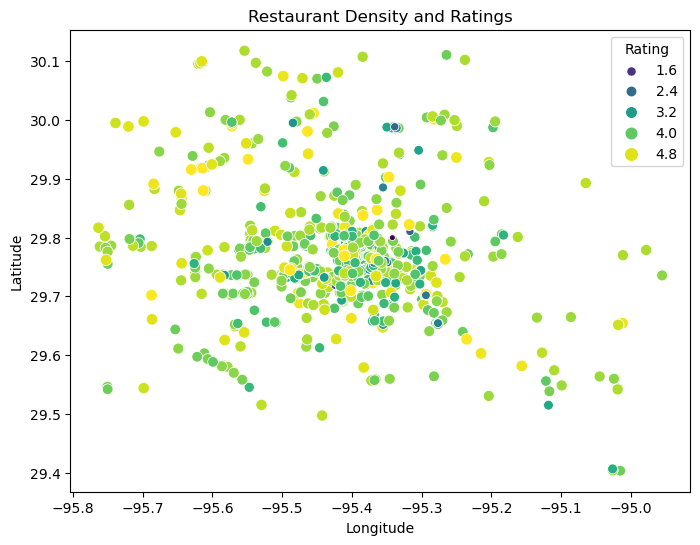

In [12]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='longitude', y='latitude', size='rating', data=df, hue='rating', palette='viridis')
plt.title('Restaurant Density and Ratings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Rating')
plt.show()

## Creating the Models ##

In [13]:
#Finding the optimal K for KNN
coords = df[['longitude','latitude']]

distortions = []

for k in range(1,25):
    kmeansModel = KMeans(n_clusters=k)
    kmeansModel = kmeansModel.fit(coords)
    distortions.append(kmeansModel.inertia_)


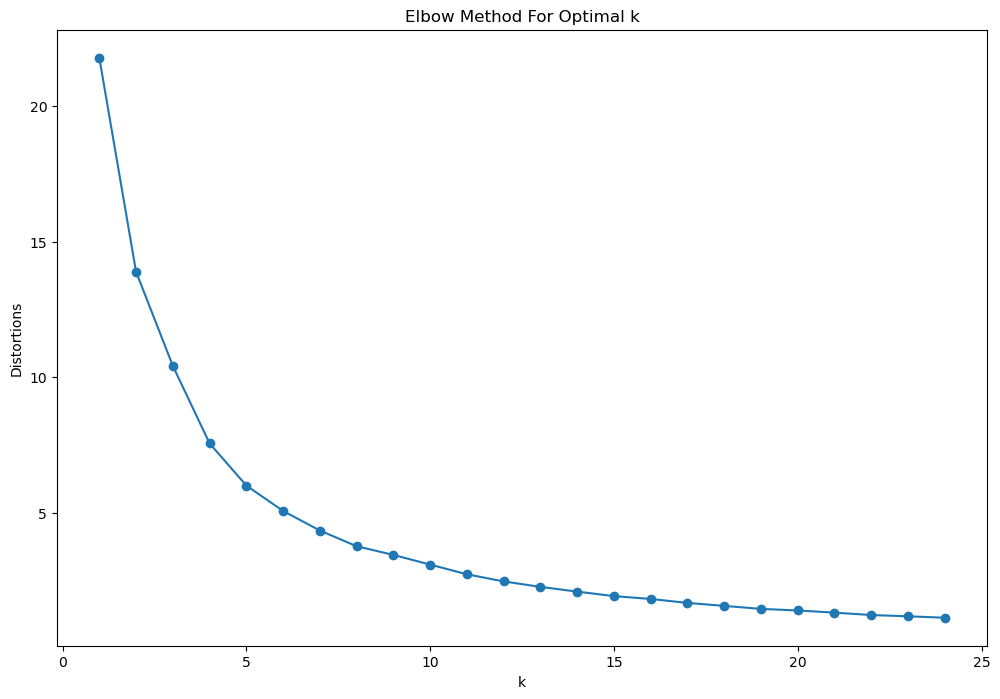

In [14]:
#Searching for the optimal K using the elbow method
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(range(1,25), distortions, marker='o')
plt.xlabel('k')
plt.ylabel('Distortions')
plt.title('Elbow Method For Optimal k')
plt.show()

In [15]:
sil = []
kmax = 25

for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(coords)
  labels = kmeans.labels_
  sil.append(silhouette_score(coords, labels, metric = 'euclidean'))

In [16]:
sil

[0.4887263628574058,
 0.4919980962722262,
 0.5343381444592579,
 0.5411656086159552,
 0.3549035042988093,
 0.45388792936298533,
 0.44459210273422267,
 0.4023855866069048,
 0.4148381090195906,
 0.4292729507462017,
 0.42995052316720117,
 0.40067522105655123,
 0.4161886872901917,
 0.41081445713398423,
 0.41565538502636656,
 0.4286072112754801,
 0.43181570910785994,
 0.43149676690733785,
 0.42107699892358436,
 0.4049708670944941,
 0.4182404687230393,
 0.43942817669831,
 0.42843568812308735,
 0.42082324487633477]

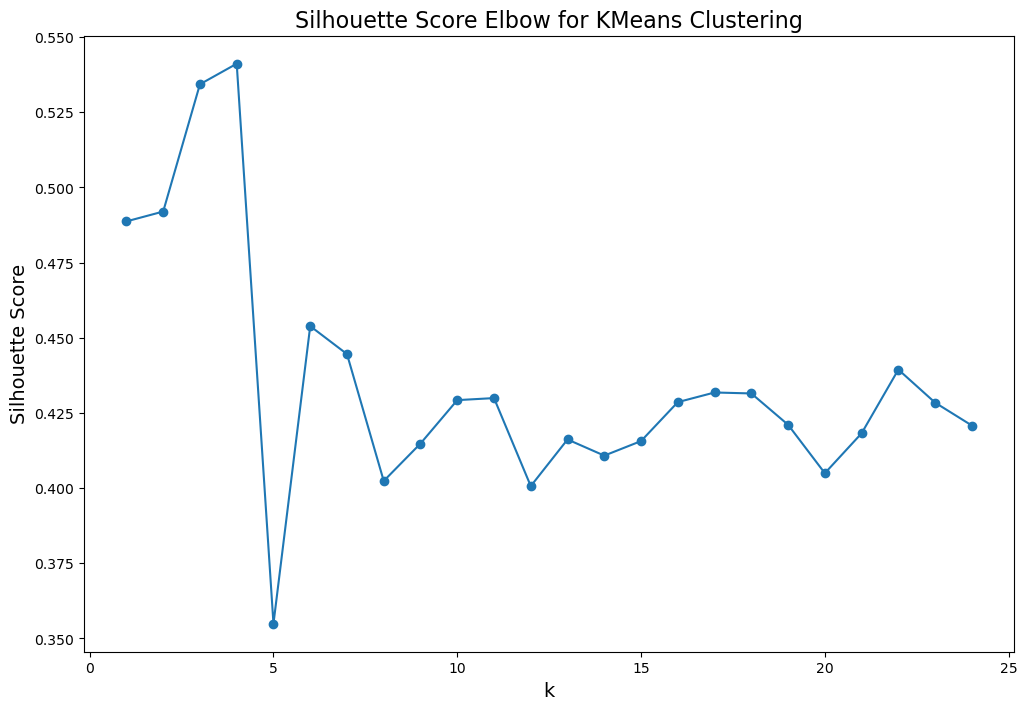

In [17]:
# Elbow Graph for Silhouette Score
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(range(1,25), sil[:24], marker='o')
plt.xlabel('k', fontsize = 14)
plt.ylabel('Silhouette Score', fontsize = 14)
plt.title('Silhouette Score Elbow for KMeans Clustering', fontsize = 16)
plt.show()

In [18]:
kmeans = KMeans(n_clusters=4, init='k-means++')
kmeans.fit(coords)
y = kmeans.labels_
print("k = 4", " silhouette_score ", silhouette_score(coords, y, metric='euclidean'))

k = 4  silhouette_score  0.5375219294196371


In [19]:
df['cluster'] = kmeans.predict(df[['longitude','latitude']])

In [20]:
def recommend_restaurants_k(df, longitude, latitude):
    start = time.time()
    # Predict the cluster for longitude and latitude provided
    cluster = kmeans.predict(np.array([longitude,latitude]).reshape(1,-1))[0]
    print("Cluster:", cluster)
    end = time.time()
    print("Time until getting a result: ", end - start)
    # Get the best restaurant in this cluster
    return  df[df['cluster']==cluster].iloc[0:10][['name', 'latitude','longitude','rating']]

###### plt.figure(figsize=(8, 6))
plt.scatter(df['longitude'], df['latitude'], c=df['cluster'], cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Restaurant Clusters')
plt.show()

In [21]:
test = {
    'longitude': [],
    'latitude': []
}

# Fixing longitude and latitude values
test['longitude'] = [29.5]
test['latitude'] = [-71]

# Creating DataFrame
user = pd.DataFrame(test)

user

,longitude,latitude
0,29.5,-71


### Exam User Test

In [22]:
#user test
recommend_restaurants_k(df, user.longitude, user.latitude)

Cluster: 2
Time until getting a result:  0.11477327346801758


,name,latitude,longitude,rating
51,Fish and Chips Houston,29.543082,-95.018019,4.6
92,The Cuban Cafe,29.654470,-95.012010,4.9
105,Asha's Roti Shop,29.735680,-94.955320,4.3
111,Broke Da Mouth Treats,29.530695,-95.203793,4.4
118,Noodle Master,29.663942,-95.134692,4.4
129,Killen's Barbecue,29.564033,-95.282281,4.2
282,The Backyard,29.559760,-95.023370,4.5
388,Master X Ramen,29.604229,-95.127405,4.6
416,The Cuban Cafe - Baytown,29.770007,-95.011461,4.5
455,Viola & Agnes' Neo Soul Cafe,29.563884,-95.044841,4.4


In [23]:
#DBSCAN Method

# Select relevant features for clustering
X = df[['rating','latitude', 'longitude']]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.3, min_samples=2)
df['cluster'] = dbscan.fit_predict(X_scaled)

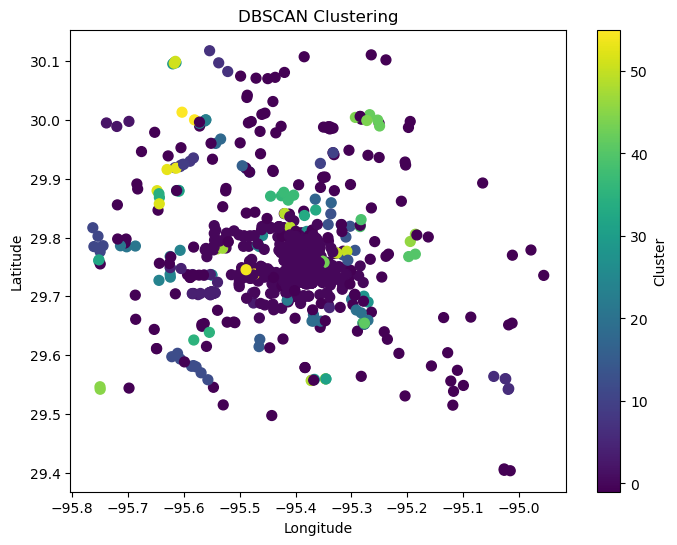

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(df['longitude'], df['latitude'], c=df['cluster'], cmap='viridis', marker='o', s=50)
plt.title('DBSCAN Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.show()

In [25]:
def calculate_silhouette_score(df, eps, min_samples):
    
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(df)

    silhouette = silhouette_score(df, labels)
    return silhouette

X = df[['rating', 'latitude', 'longitude']]
calculate_silhouette_score(X, 0.3, 2)

0.6993580878386745

In [26]:
def recommend_restaurants_db(df, longitude, latitude):
    #Predict the cluster for longitude and latitude provided
    start =time.time()
    cluster = dbscan.fit_predict(np.array([longitude,latitude]).reshape(1,-1))[0]
    print(cluster)
    end = time.time()
    print("Time until getting a result: ", end - start)
    #Get the best restaurant in this cluster
    return df[df['cluster']==cluster].iloc[0:10][['name', 'latitude','longitude','rating']]

### Exam User Test

In [27]:
#test
recommend_restaurants_db(df, user.longitude, user.latitude)

-1
Time until getting a result:  0.0038900375366210938


,name,latitude,longitude,rating
28,The Ginger Mule,29.803238,-95.405455,4.7
45,Stone Age Street Food,29.705436,-95.546444,4.9
62,The French Fry House,29.681290,-95.319990,4.5
72,House of Fries,29.843105,-95.472766,4.5
74,Sushi Tex Mex,29.902729,-95.350003,4.8
76,Da Food Plug Htx,30.001245,-95.282083,5.0
83,Baguettea,29.942530,-95.462700,4.9
92,The Cuban Cafe,29.654470,-95.012010,4.9
105,Asha's Roti Shop,29.735680,-94.955320,4.3
109,Bamboo House,29.939870,-95.270260,4.4


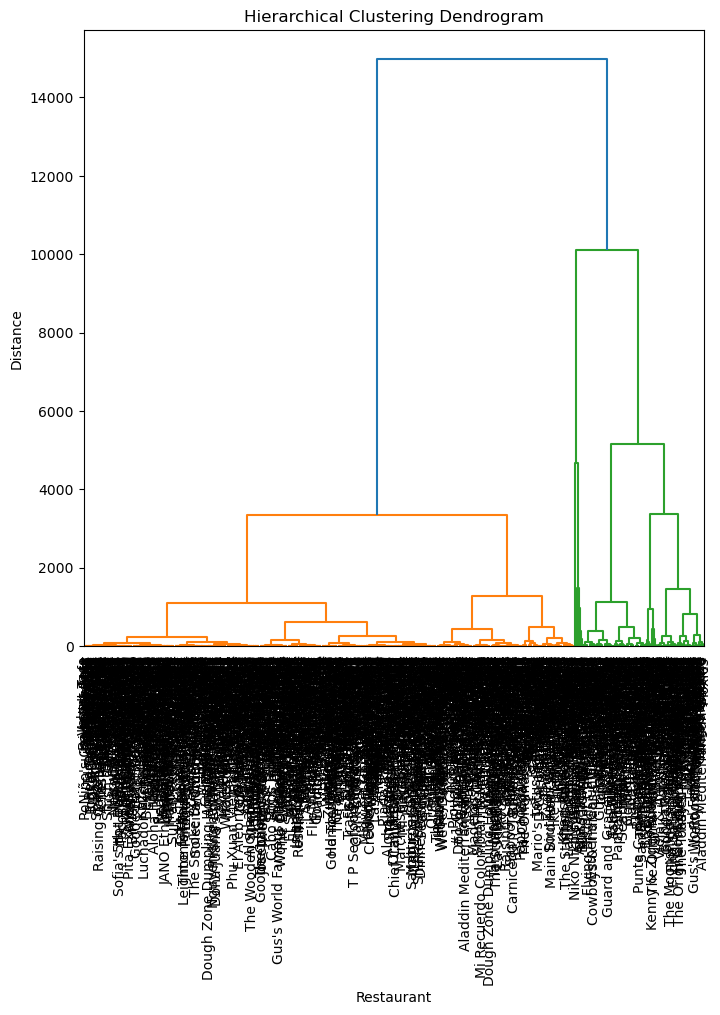

In [28]:

# Select relevant features for clustering
X = df[['rating', 'review_count', 'longitude', 'latitude']]

# Perform hierarchical clustering
Z = linkage(X, method='ward', metric='euclidean')

# Plot dendrogram
plt.figure(figsize=(8, 8))
dendrogram(Z, labels=df['name'].values, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Restaurant')
plt.ylabel('Distance')
plt.show()

In [29]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import cdist

def predict_location_cluster(locations, new_location, k=3):
   
    # Select relevant features for clustering
    X = locations[['latitude', 'longitude']].to_numpy()

    # Perform hierarchical clustering
    Z = linkage(X, method='ward')

    # Assign clusters to data points
    clusters = fcluster(Z, k, criterion='maxclust')

    # Calculate distances to cluster centroids
    centroids = np.array([np.mean(X[clusters == i], axis=0) for i in range(1, k+1)])
    distances = cdist(np.array([new_location]), centroids)

    silhoette_avg = silhouette_score(X, clusters)
    print("The silhouette score is: ", silhoette_avg)
    # Predict cluster for new location
    predicted_cluster = np.argmin(distances) + 1  # +1 because cluster indexing starts from 1

    return predicted_cluster

### Exam User Test

In [30]:
user = [29.5, -71.0]

In [31]:
# test user 1
# Predict the cluster for the new location
predicted_cluster = predict_location_cluster(df, user)
print(predicted_cluster)
print("The new location is predicted to be in cluster", predicted_cluster)

suggest_cl = df[df["cluster"] == predicted_cluster].sort_values(by=['review_count', 'rating'], ascending=False).iloc[:10][['name', 'latitude','longitude','rating']]
suggest_cl

The silhouette score is:  0.4363348031060005
1
The new location is predicted to be in cluster 1


,name,latitude,longitude,rating
13,Sao Lao Thai Café,29.839837,-95.411252,4.7
206,Ploughman's Deli & Cafe,29.840683,-95.420117,4.7


In [32]:
!pip freeze > requirements.txt